## K-Means Clustering on Frailty
#### By Gavin Qu, Aug 11th 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
df = pd.read_csv('/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_long_panel.csv')

In [11]:
df.head(2)

,pidp,age_dv,disdif1,disdif2,disdif3,disdif4,disdif5,disdif6,disdif7,disdif8,...,healthcond9,healthcond10,healthcond11,healthcond12,healthcond13,healthcond14,healthcond15,healthcond16,death,frailty
0,22445,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.037037
1,22445,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.037037


In [9]:
df_frailty = df[['pidp', 'wave', 'age_dv', 'death', 'frailty']]
df_frailty.head(2)

,pidp,wave,age_dv,death,frailty
0,22445,d,27.0,0,0.037037
1,22445,e,28.0,0,0.037037


In [10]:
df_frailty.describe()

,pidp,age_dv,death,frailty
count,5.379200e+05,537888.000000,537920.000000,529303.000000
mean,7.789122e+08,48.326057,0.008261,0.057325
std,4.651049e+08,18.842408,0.090516,0.116342
min,2.244500e+04,0.000000,0.000000,0.000000
25%,4.080830e+08,33.000000,0.000000,0.000000
50%,7.483869e+08,48.000000,0.000000,0.037037
75%,1.157245e+09,63.000000,0.000000,0.074074
max,1.653277e+09,105.000000,1.000000,1.000000


In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### K-means Implementation
We will treat health trajectory of each person over the clustering period as a vector, then remove those with NaN values.

In [42]:
# Filter data for ages 50 to 60
df_filtered = df_frailty[(df_frailty['age_dv'] >= 50) & (df_frailty['age_dv'] <= 60)]

# Create health trajectory vectors
def create_health_vector(group):
    return [group.get(age, np.nan) for age in range(50, 61, 2)] # step size = 2 as in the slides due to data availability

health_trajectories = df_filtered.groupby('pidp').apply(
    lambda x: create_health_vector(x.set_index('age_dv')['frailty'].to_dict())
).tolist()

# Remove any trajectories with NaN values
health_trajectories = [h for h in health_trajectories if not any(np.isnan(h))]

# Convert to numpy array
X = np.array(health_trajectories)

X_scaled = X # no need to normalize here

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/3143006359.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  health_trajectories = df_filtered.groupby('pidp').apply(


In [43]:
def kmeans_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans

#### Elbow Method
The elbow method plot shows the relationship between the number of clusters (k) and the inertia (within-cluster sum of squares). Here's how to interpret it:
1) Look for an "elbow" point in the plot where the rate of decrease sharply changes.
2) This point represents a good balance between cluster coherence and number of clusters.
3) After this point, adding more clusters doesn't significantly reduce inertia.

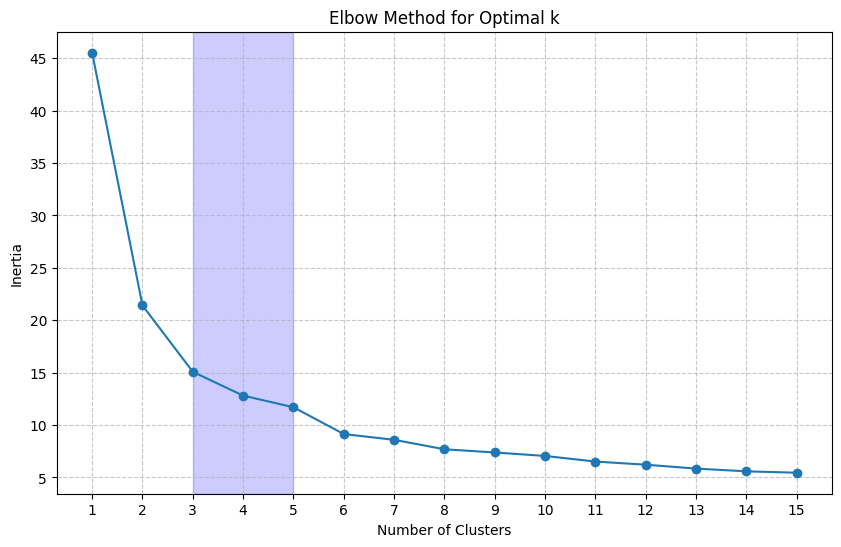

In [44]:
def elbow_method(X, max_clusters=15, highlight_range=(3, 5)):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = kmeans_clustering(X, k)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    
    # Add shaded region
    plt.axvspan(highlight_range[0], highlight_range[1], alpha=0.2, color='blue')
    
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Assuming X_scaled is your scaled data
elbow_method(X_scaled)

#### Silhouette Method
The silhouette method measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where higher values indicate better-defined clusters. 

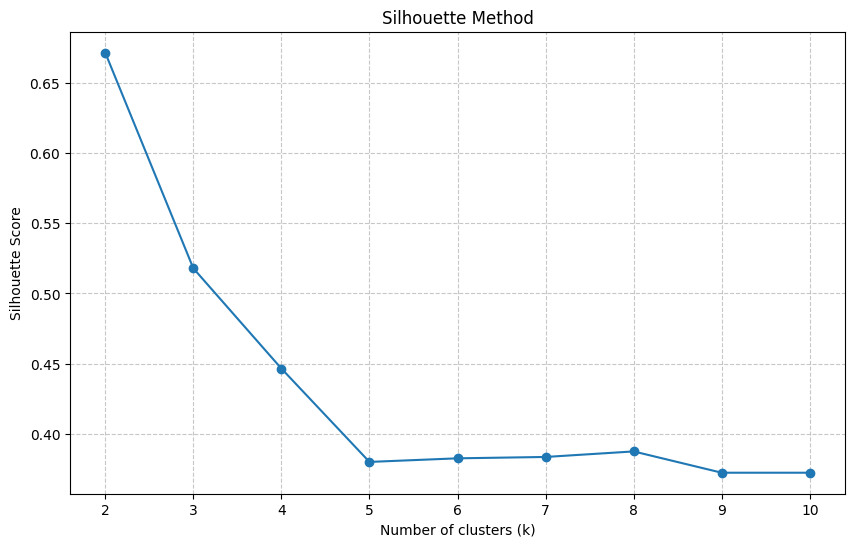

In [45]:
def silhouette_method(X, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):  # Start from 2 clusters
        kmeans = kmeans_clustering(X, k)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(2, max_clusters + 1))
    plt.show()

silhouette_method(X_scaled)

### Economic Interpretations
*Skip for now*

Elbow method: Decent decrease in loss criterion from 2 to 3 clusters, with smaller decreases after 3 clusters.
Silhouette method: Big decreases in loss criterion until k=5, so we should opt for k=4 clusters as a midpoint. 

### Descriptive Stats and Plots

Describing the characteristics of each of your K=4 clusters i.e. show their: 
- Average Frailty trajectories as in the figure below from De Nardi et al
- Employment status – e.g. you could show what fraction of each cluster are employed and inactive by age
- Earnings status – average earnings of each cluster by age

**First**, I will create a new column and assign each 'pidp' into a cluster. 

In [46]:
from sklearn.cluster import KMeans

# we already created health_trajectories

# Perform K-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(health_trajectories)

# Create a dictionary mapping pidp to cluster
pidp_to_cluster = dict(zip(df_frailty['pidp'].unique(), cluster_labels))

# Add a new column to df_frailty with cluster assignments
df_frailty['cluster'] = df_frailty['pidp'].map(pidp_to_cluster)

# Verify the new column
print(df_frailty[['pidp', 'age_dv', 'frailty', 'cluster']].head(5))

# Count the number of individuals in each cluster
cluster_counts = df_frailty['cluster'].value_counts().sort_index()
cluster_percentages = cluster_counts / len(df_frailty['pidp'].unique()) * 100

print("\nCluster distribution:")
for cluster, count in cluster_counts.items():
    percentage = cluster_percentages[cluster]
    print(f"Cluster {cluster}: {count} individuals ({percentage:.1f}%)")

    pidp  age_dv   frailty  cluster
0  22445    27.0  0.037037      0.0
1  22445    28.0  0.037037      0.0
2  22445    29.0  0.037037      0.0
3  22445    30.0  0.037037      0.0
4  22445    31.0  0.037037      0.0

Cluster distribution:
Cluster 0.0: 1745 individuals (1.9%)
Cluster 1.0: 4412 individuals (4.9%)
Cluster 2.0: 334 individuals (0.4%)
Cluster 3.0: 666 individuals (0.7%)


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/2789517004.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frailty['cluster'] = df_frailty['pidp'].map(pidp_to_cluster)


In [49]:
df_frailty.tail(5)

,pidp,wave,age_dv,death,frailty,cluster,death_count
537915,1653277290,f,37.0,0,0.0,NaN,NaN
537916,1653277290,g,38.0,0,0.0,NaN,NaN
537917,1653277290,h,39.0,0,0.0,NaN,NaN
537918,1653277290,i,40.0,0,0.0,NaN,NaN
537919,1653277290,k,42.0,0,0.0,NaN,NaN


In [53]:
df_frailty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537920 entries, 0 to 537919
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   pidp         537920 non-null  int64  
 1   wave         537920 non-null  object 
 2   age_dv       537888 non-null  float64
 3   death        537920 non-null  int64  
 4   frailty      529303 non-null  float64
 5   cluster      7157 non-null    float64
 6   death_count  6401 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 28.7+ MB


In [52]:
# Count unique pidp with non-NaN frailty
non_nan_frailty_count = df_frailty[df_frailty['frailty'].notna()]['pidp'].nunique()
print(f"Number of unique pidp with non-NaN frailty: {non_nan_frailty_count}")

# since we used a specific age range for clustering, check how many pidp have data in that range
age_range_pidp = df_frailty[(df_frailty['age_dv'] >= 50) & (df_frailty['age_dv'] <= 60)]['pidp'].nunique()
print(f"\nNumber of unique pidp in age range 50-60: {age_range_pidp}")

# Count unique pidp used in clustering (non-NaN cluster)
clustered_pidp_count = df_frailty[df_frailty['cluster'].notna()]['pidp'].nunique()
print(f"Number of unique pidp used in clustering: {clustered_pidp_count}")

# Total unique pidp
total_pidp_count = df_frailty['pidp'].nunique()
print(f"Total number of unique pidp: {total_pidp_count}")

# Distribution of frailty values
print("\nDistribution of frailty values:")
print(df_frailty['frailty'].describe())

# Check for any pidp with all NaN frailty values
all_nan_frailty = df_frailty.groupby('pidp')['frailty'].apply(lambda x: x.isna().all())
pidp_all_nan_frailty = all_nan_frailty[all_nan_frailty].index
print(f"\nNumber of pidp with all NaN frailty values: {len(pidp_all_nan_frailty)}")

# Check the age range used for clustering
print("\nAge range in the dataset:")
print(df_frailty['age_dv'].describe())

Number of unique pidp with non-NaN frailty: 84494

Number of unique pidp in age range 50-60: 21641
Number of unique pidp used in clustering: 1119
Total number of unique pidp: 89601

Distribution of frailty values:
count    529303.000000
mean          0.057325
std           0.116342
min           0.000000
25%           0.000000
50%           0.037037
75%           0.074074
max           1.000000
Name: frailty, dtype: float64

Number of pidp with all NaN frailty values: 5107

Age range in the dataset:
count    537888.000000
mean         48.326057
std          18.842408
min           0.000000
25%          33.000000
50%          48.000000
75%          63.000000
max         105.000000
Name: age_dv, dtype: float64


**The following plot effectively illustrates different health dynamics across various health types (clusters), both during and after the clustering period.**

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/2800959602.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['age_bins'] = pd.cut(df_filtered['age_dv'], bins=range(50, 111, 2), right=False) # bins = 2
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/2800959602.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df_filtered.groupby(['age_bins', 'cluster'])['frailty'].mean().unstack()


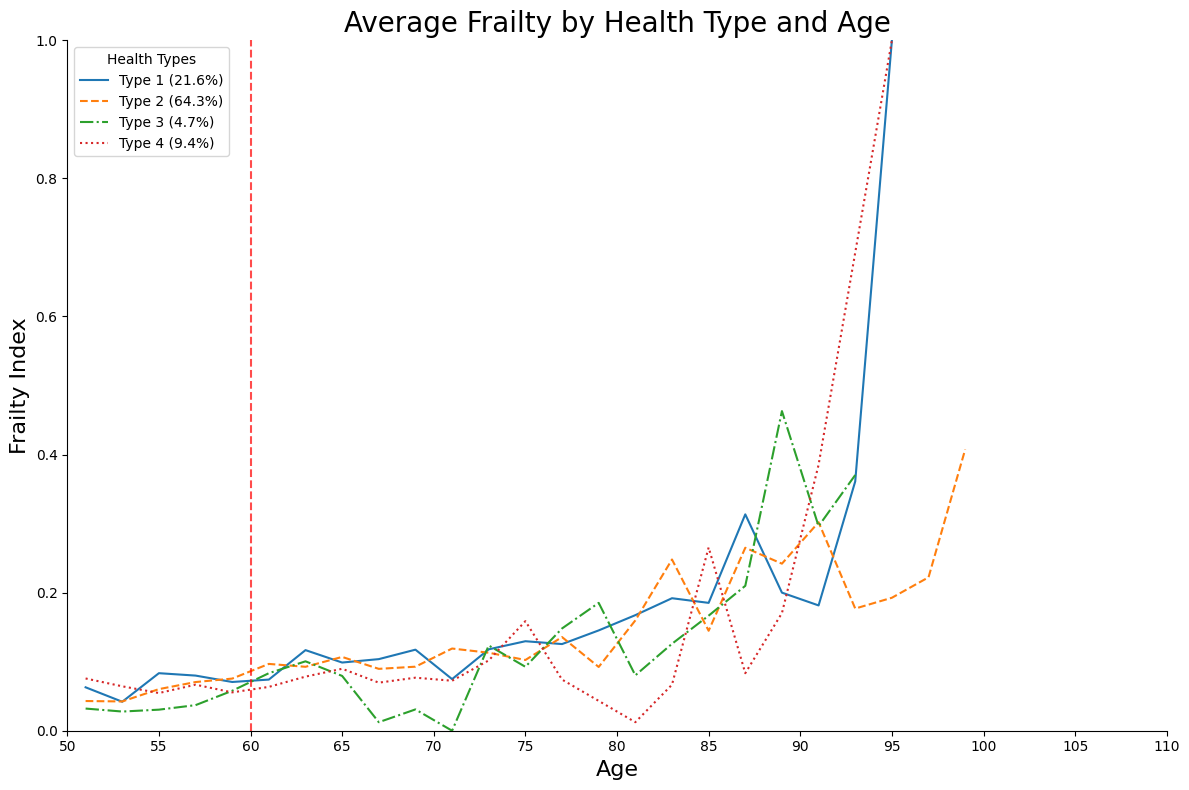

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df_frailty is your dataframe with the cluster information
df_filtered = df_frailty[(df_frailty['age_dv'] >= 50) & (df_frailty['age_dv'] <= 110) & (~np.isnan(df_frailty['frailty'])) & (~np.isnan(df_frailty['cluster']))]

# Create age bins
df_filtered['age_bins'] = pd.cut(df_filtered['age_dv'], bins=range(50, 111, 2), right=False) # bins = 2 

# Calculate mean frailty for each bin and cluster
binned_data = df_filtered.groupby(['age_bins', 'cluster'])['frailty'].mean().unstack()

# Calculate the midpoint of each age bin for plotting
binned_data['age_mid'] = binned_data.index.map(lambda x: x.mid)

# Calculate the percentage of individuals in each cluster
cluster_percentages = df_filtered['cluster'].value_counts(normalize=True) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

linestyles = ['-', '--', '-.', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # You can adjust these colors

for cluster in range(4):
    cluster_data = binned_data[cluster].dropna()
    ax.plot(cluster_data.index.map(lambda x: x.mid), cluster_data.values,
            label=f'Type {cluster+1} ({cluster_percentages[cluster]:.1f}%)',
            linestyle=linestyles[cluster % len(linestyles)],
            color=colors[cluster % len(colors)])

ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Frailty Index', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a vertical line at age 60
ax.axvline(x=60, color='red', linestyle='--', alpha=0.7)

ax.set_title('Average Frailty by Health Type and Age', fontsize=20)
ax.legend(title='Health Types', loc='upper left')

ax.set_xlim(50, 110)
ax.set_ylim(0, 1)
ax.set_xticks(range(50, 111, 5))

plt.tight_layout()
plt.show()

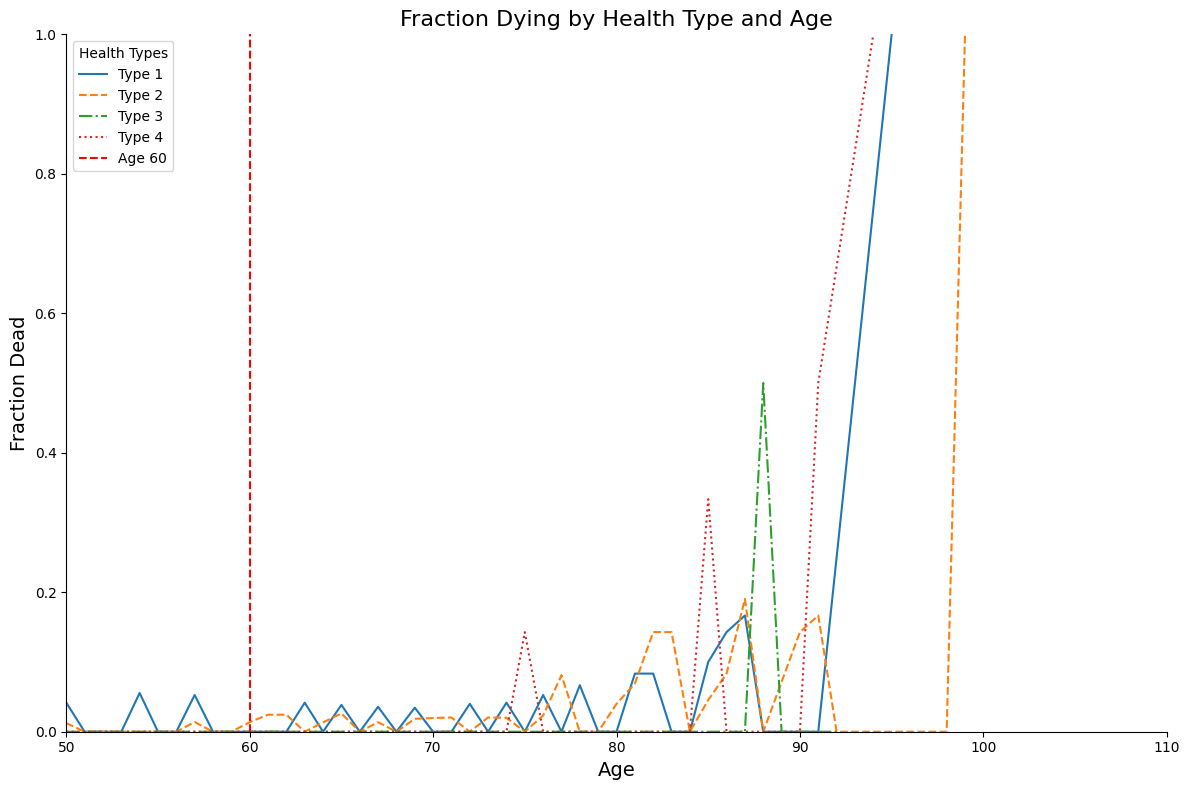

         age_dv                                                      frailty  \
          count       mean        std   min   25%   50%    75%   max   count   
cluster                                                                        
0.0       740.0  67.617568  10.301856  50.0  60.0  67.0  75.00  95.0   734.0   
1.0      2198.0  65.324841  10.655999  50.0  57.0  64.0  73.00  99.0  2184.0   
2.0       160.0  63.831250  12.178557  50.0  54.0  59.0  70.25  92.0   158.0   
3.0       320.0  65.456250   9.914902  50.0  58.0  65.0  71.00  94.0   319.0   

                                                                     
             mean       std  min       25%       50%       75%  max  
cluster                                                              
0.0      0.113584  0.169365  0.0  0.000000  0.074074  0.148148  1.0  
1.0      0.100495  0.156495  0.0  0.000000  0.055556  0.111111  1.0  
2.0      0.082044  0.118997  0.0  0.000000  0.037037  0.148148  1.0  
3.0      0.088935  

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df_frailty is your dataframe with the cluster information
df_filtered = df_frailty[(df_frailty['age_dv'] >= 50) & (df_frailty['age_dv'] <= 110) & (~np.isnan(df_frailty['cluster']))]

fig, ax = plt.subplots(figsize=(12, 8))

# Calculate fraction dead (frailty == 1) by age and cluster
fraction_dead = df_filtered.groupby(['age_dv', 'cluster'])['frailty'].apply(lambda x: (x == 1).mean()).unstack()

# Plot fraction dead for each cluster
linestyles = ['-', '--', '-.', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, cluster in enumerate(fraction_dead.columns):
    cluster_data = fraction_dead[cluster].dropna()
    ax.plot(cluster_data.index, cluster_data.values, 
            color=colors[i % len(colors)],
            linestyle=linestyles[i % len(linestyles)],
            label=f'Type {i + 1}')

ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Fraction Dead', fontsize=14)

# Add a vertical line at age 60
plt.axvline(x=60, color='red', linestyle='--', label='Age 60')

plt.title('Fraction Dying by Health Type and Age', fontsize=16)

# Set axis limits
ax.set_xlim(50, 110)
ax.set_ylim(0, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
ax.legend(title='Health Types', loc='upper left')

plt.tight_layout()
plt.show()

# Print some summary statistics
print(df_filtered.groupby('cluster')[['age_dv', 'frailty']].describe())

# Print the number of deaths (frailty == 1) for each cluster
num_deaths = df_filtered.groupby('cluster')['frailty'].apply(lambda x: x.eq(1).sum())
print("\nNumber of deaths (frailty == 1) by cluster:")
print(num_deaths)

# Calculate and print the percentage of individuals in each cluster
cluster_percentages = df_filtered['cluster'].value_counts(normalize=True) * 100
print("\nPercentage of individuals in each cluster:")
print(cluster_percentages)